# Variational Autoencoders (VAE)

#### This notebook is inspired from keras tutorial on [Variational Autoencoders](https://keras.io/examples/generative/vae/)
- In this notebook, VAE has been trained on MNIST digits dataset.
- Encoder and Decoder architectures have been modified. 
- Two VAE models, one with 2 dimensional latent space and the other with 9 dimensional latent space has been trained. 
- Latent space of each class has been visualized. 

## 1. Import necessary modules

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

print(f'Tensorflow version: {tf.__version__}')
tf.random.set_seed(1234)

Tensorflow version: 2.4.0


## 2. Load and prepare MNIST dataset

### 2.1 Load MNIST dataset

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

# check the shape of the data
print(f'Shape of x_train: {x_train.shape}\nShape of x_test: {x_test.shape}')

Shape of x_train: (60000, 28, 28)
Shape of x_test: (10000, 28, 28)


### 2.2 Reshape data by adding channel dimension

In [3]:
# Set the input shape for the encoder model
INPUT_SHAPE = (28, 28, 1)

# concatenate train and test data
train_data = np.concatenate((x_train, x_test), axis = 0)

# rescale the data
train_data = train_data.reshape((-1, ) + INPUT_SHAPE).astype('float32') / 255.0

# check the shape 
print(f'Shape of train_data: {train_data.shape}')

Shape of train_data: (70000, 28, 28, 1)


## 3. Build VAE model

### 3.1 Define Sampling Layer 

In [4]:
class Sampling(layers.Layer):
  """
  Uses (mean, log_var) to sample z_vector, the vector encoding a digit.
  """
  def call(self, parameters):
    mean_vector, log_var_vector = parameters
    batch_size = tf.shape(mean_vector)[0]
    z_dim = tf.shape(mean_vector)[1]

    # sample from the standard normal distribution
    epsilon = K.random_normal(shape = (batch_size, z_dim))

    # construct the input for the decoder
    z_vector = mean_vector + tf.exp(0.5 * log_var_vector) * epsilon
    return z_vector

### 3.2 CNN based encoder model

In [5]:
def create_encoder(latent_dim = 2):
  """
  This function will create the encoder model 

  Args: 
    latent_dim: dimension of the latent space into which encoder will encode the input data
  """
  # input layer for the encoder
  encoder_inputs = layers.Input(shape = INPUT_SHAPE, name = 'encoder_input')

  # strided convolution layers
  x = layers.Conv2D(128, (5, 5), activation = 'relu', strides = 2, padding = 'same', name = 'conv_1')(encoder_inputs)
  x = layers.Conv2D(64, (5, 5), activation = 'relu', strides = 2, padding = 'same', name = 'conv_2')(x)
  x = layers.Conv2D(32, (5, 5), activation = 'relu', strides = 2, padding = 'same', name = 'conv_3')(x)

  # flatten the feature maps into 1-D vector
  x = layers.Flatten(name = 'flatten')(x)
  x = layers.Dense(16, activation = 'relu', name = 'dense_1')(x)

  # mean and variance vector
  mean_vector = layers.Dense(latent_dim, name = 'mean_vector')(x)
  log_var_vector = layers.Dense(latent_dim, name = 'log_var_vector')(x)

  # sampled vector
  z_vector = Sampling(name = 'sampling_layer')([mean_vector, log_var_vector])

  encoder = tf.keras.Model(encoder_inputs, [mean_vector, log_var_vector, z_vector], name = 'encoder')
  return encoder

In [6]:
## call the function to create the encoder model
encoder = create_encoder(latent_dim = 2)

## print the summary of the model
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 14, 14, 128)  3328        encoder_input[0][0]              
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 7, 7, 64)     204864      conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 4, 4, 32)     51232       conv_2[0][0]                     
____________________________________________________________________________________________

### 3.3 CNN based decoder model

In [7]:
def create_decoder(latent_dim = 2):
  """
  This function will create the decoder model

  Args:
    latent_dim: latent space dimension from which the decoder will construct the data
  """
  # input layer for the decoder 
  latent_inputs = layers.Input(shape = (latent_dim, ), name = 'decoder_input')
  x = layers.Dense(7 * 7 * 128, activation = 'relu', name = 'dense_1')(latent_inputs)
  x = layers.Reshape((7, 7, 128), name = 'reshape_layer')(x)

  # Upsampling ==> Conv layers block to increase spatial dimension of the image
  x = layers.UpSampling2D(name = 'upsample_1')(x)
  x = layers.Conv2D(64, (4, 4), activation = 'relu', padding = 'same', name = 'conv_1')(x)

  x = layers.UpSampling2D(name = 'upsample_2')(x)
  x = layers.Conv2D(64, (4, 4), activation = 'relu', padding = 'same', name = 'conv_2')(x)

  decoder_outputs = layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same', name = 'conv_3')(x)

  decoder = tf.keras.Model(latent_inputs, decoder_outputs, name = 'decoder')
  return decoder

In [8]:
## Call the function to create the decoder model
decoder = create_decoder(latent_dim = 2)

# print the summary of the decoder model
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              18816     
_________________________________________________________________
reshape_layer (Reshape)      (None, 7, 7, 128)         0         
_________________________________________________________________
upsample_1 (UpSampling2D)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 14, 14, 64)        131136    
_________________________________________________________________
upsample_2 (UpSampling2D)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 64)        6560

## 4. Train the model

### 4.1 Define custom training step

In [9]:
# Define VAE class by subclassing tf.keras.Model class
class VAE(tf.keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

  # train step function
  def train_step(self, data):
    if isinstance(data, tuple):
      data = data[0]

    # GradientTape to record the forward pass to calculate the gradients
    with tf.GradientTape() as tape:
      # forward pass of the encoder model
      mean_vector, log_var_vector, z_vector = self.encoder(data)
      # forward pass of the decoder model
      reconstructed_data = self.decoder(z_vector)

      # calculate reconstruction loss
      reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, reconstructed_data)) * 784

      # calculate KL divergence loss
      kl_loss = 1 + log_var_vector - tf.square(mean_vector) - tf.exp(log_var_vector)
      kl_loss = -0.5 * tf.reduce_mean(kl_loss)

      # total loss of the VAE Model
      total_loss = reconstruction_loss + kl_loss

    # calculate gradients 
    grads = tape.gradient(total_loss, self.trainable_weights)
    # update weights
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # return the losses
    return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

### 4.2 Compile and fit the VAE model

In [10]:
# instantiate VAE class object 
vae_model = VAE(encoder, decoder)

vae_model.compile(optimizer = tf.keras.optimizers.Adam())
vae_model.fit(train_data, epochs = 20, batch_size = 128)

Epoch 1/20
547/547 [==============================] - 14s 21ms/step - loss: 179.1432 - reconstruction_loss: 176.6950 - kl_loss: 2.4482
Epoch 2/20
547/547 [==============================] - 11s 20ms/step - loss: 154.7109 - reconstruction_loss: 151.4818 - kl_loss: 3.2292
Epoch 3/20
547/547 [==============================] - 11s 20ms/step - loss: 150.2732 - reconstruction_loss: 146.9032 - kl_loss: 3.3700
Epoch 4/20
547/547 [==============================] - 11s 20ms/step - loss: 147.6354 - reconstruction_loss: 144.1817 - kl_loss: 3.4537
Epoch 5/20
547/547 [==============================] - 11s 20ms/step - loss: 145.8337 - reconstruction_loss: 142.3375 - kl_loss: 3.4961
Epoch 6/20
547/547 [==============================] - 11s 20ms/step - loss: 144.5593 - reconstruction_loss: 141.0218 - kl_loss: 3.5376
Epoch 7/20
547/547 [==============================] - 11s 21ms/step - loss: 143.5654 - reconstruction_loss: 139.9942 - kl_loss: 3.5713
Epoch 8/20
547/547 [==============================] - 1

## 5. Plot the images and latent space 

In [11]:
def plot_latent(encoder, decoder):
  # display n * n 2D manifold of digits
  n = 30
  digit_size = 28
  scale = 2.0
  figsize = 15
  figure = np.zeros((digit_size * n, digit_size * n))

  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = digit

  plt.figure(figsize = (figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap = "Greys_r")
  plt.show()

### 5.1 Plot the images generated by the decoder model 

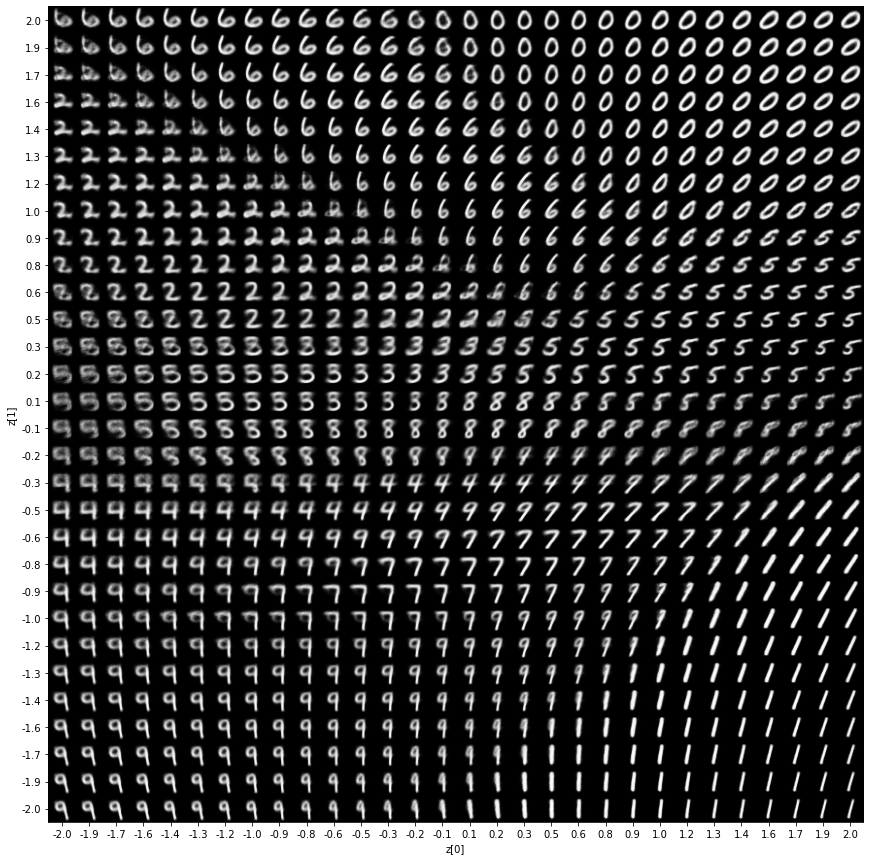

In [12]:
plot_latent(encoder, decoder)

### 5.2 Plot the latent space

In [13]:
def plot_label_clusters(encoder, decoder, data, labels):
  # display a 2D plot of the digit classes in the latent space
  z_mean, _, _ = encoder.predict(data)
  plt.figure(figsize = (12, 10))
  plt.scatter(z_mean[:, 0], z_mean[:, 1], c = labels)
  plt.colorbar()
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.show()

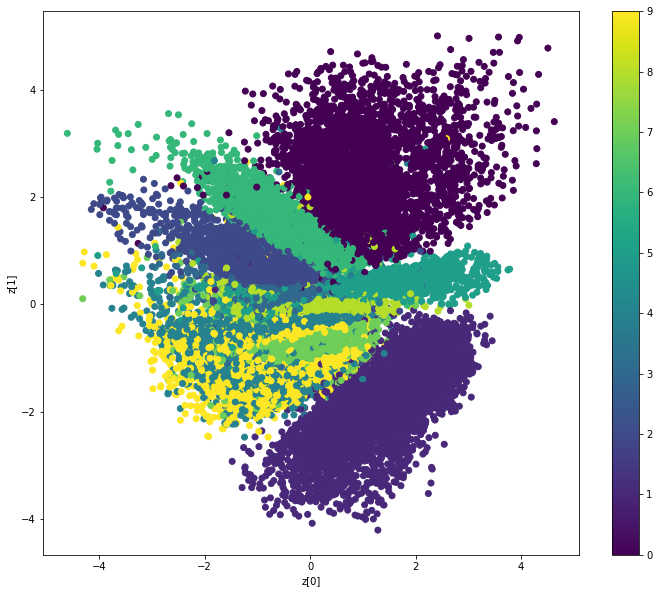

In [14]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)

### 5.3 Gaussian distribution of latent space

In [17]:
# get the latent space representation of x_train
_, _, z_vector = encoder.predict(x_train)

# construct data frame with latent variables and labels
df = pd.DataFrame({'z_1': z_vector[:, 0], 'z_2': z_vector[:, 1], 'labels': y_train})

# display head of the dataframe
df.head()

,z_1,z_2,labels
0,-0.066860,0.152380,5
1,1.067822,1.838295,0
2,-1.491607,-0.679772,4
3,2.229739,-0.929558,1
4,0.041700,-1.205288,9


In [18]:
def plot_gaussian(class_label):
  """ This function will plot the gaussian distribution of latent space for 
      each class in the mnist data set
  """
  # filter the dataframe for the given class label
  class_df = df[df.labels == class_label][['z_1', 'z_2']]

  fig, ax = plt.subplots(1, 3, figsize = (12, 4))
  # plot latent dimensions
  ax[0].hist(class_df.iloc[:, 0], bins = 100, density = True)
  ax[1].hist(class_df.iloc[:, 1], bins = 100, density = True)
  sns.kdeplot(x = class_df.iloc[:, 0], y = class_df.iloc[:, 1], ax = ax[2])
  plt.title(f'Distribution of Class {class_label} vectors')

#### 5.3.1 Distribution of class 0

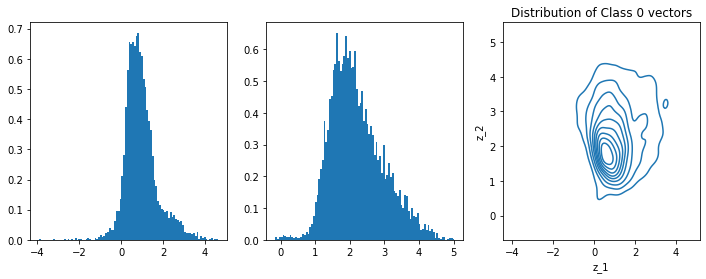

In [19]:
plot_gaussian(0)

#### 5.3.2 Distribution of class 1

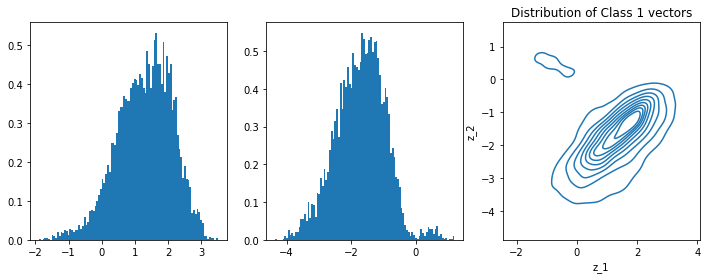

In [20]:
plot_gaussian(1)

#### 5.3.3 Distribution of class 2

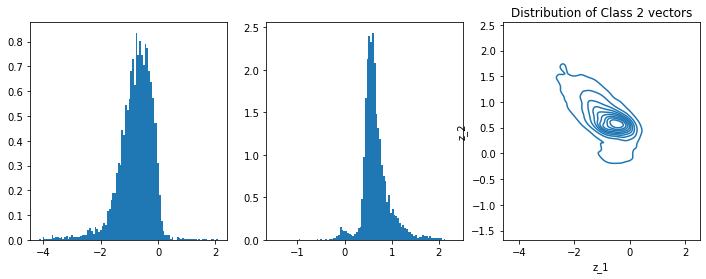

In [21]:
plot_gaussian(2)

#### 5.3.4 Distribution of class 3

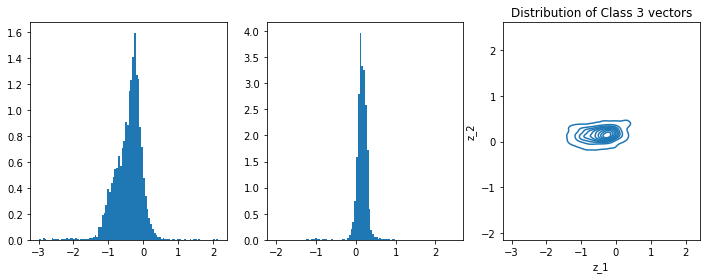

In [22]:
plot_gaussian(3)

#### 5.3.5 Distribution of class 4

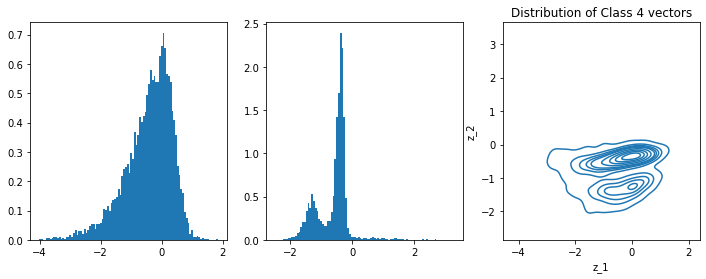

In [23]:
plot_gaussian(4)

#### 5.3.6 Distribution of class 5

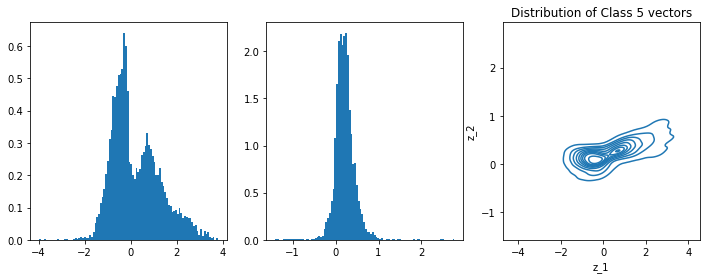

In [24]:
plot_gaussian(5)

#### 5.3.7 Distribution of class 6

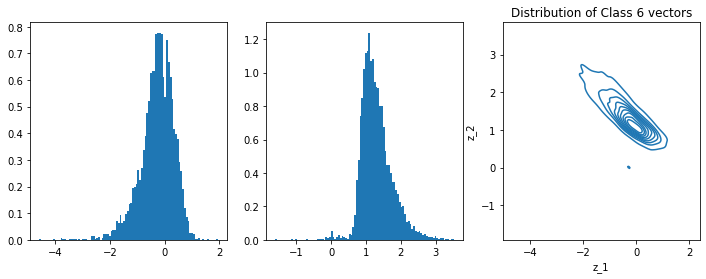

In [25]:
plot_gaussian(6)

#### 5.3.8 Distribution of class 7

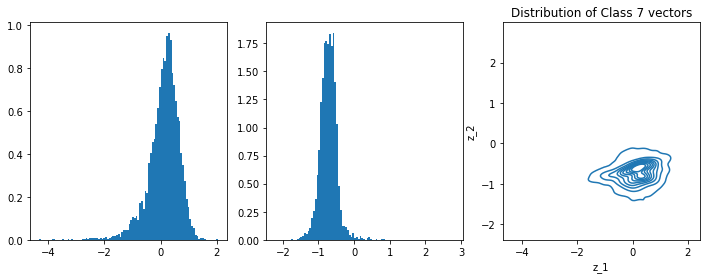

In [26]:
plot_gaussian(7)

#### 5.3.9 Distribution of class 8

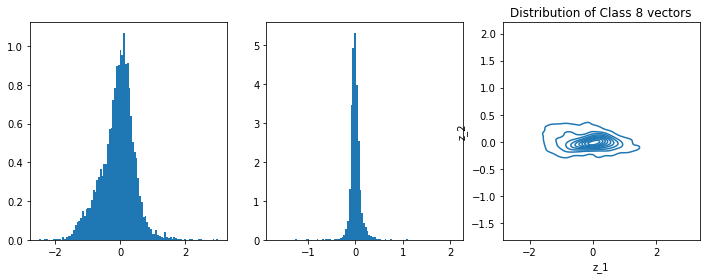

In [27]:
plot_gaussian(8)

#### 5.3.10 Distribution of class 9

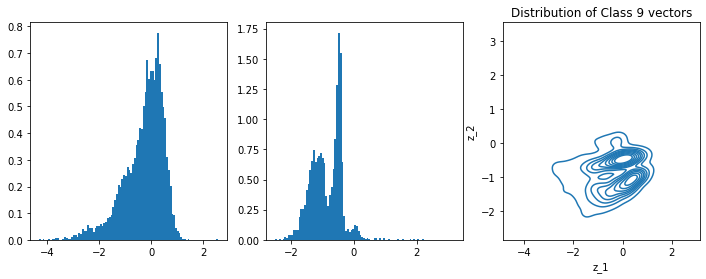

In [28]:
plot_gaussian(9)

## 6. Interactive visualizations

### 6.1 Import modules for interactive visualization

In [29]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

### 6.2 Helper function to create sliders to vary latent space variables

In [31]:
@interact(x = widgets.FloatSlider(min = -15, max = 15), y = widgets.FloatSlider(min = -15, max = 15))
def decorator(x, y):
  """
  This function will construct the images for given x and y.
  These can be changed dynamically using sliders
  """
  z_sample = np.array([[x, y]])
  x_decoded = decoder.predict(z_sample)
  plt.imshow(x_decoded[0].reshape(28, 28), cmap = 'gray')

interactive(children=(FloatSlider(value=0.0, description='x', max=15.0, min=-15.0), FloatSlider(value=0.0, des…

- Move the slider to generate different digits

## 7. VAE model with 9 dim latent space representation

### 7.1 Build and train the VAE model

In [32]:
# create encoder and decoder models
enc_model = create_encoder(latent_dim = 9)
dec_model = create_decoder(latent_dim = 9)

# instantiate VAE class object 
vae_latent_dim_9 = VAE(enc_model, dec_model)

# compile and fit the model
vae_latent_dim_9.compile(optimizer = tf.keras.optimizers.Adam())
vae_latent_dim_9.fit(train_data, epochs = 20, batch_size = 128)

Epoch 1/20
547/547 [==============================] - 12s 20ms/step - loss: 149.0919 - reconstruction_loss: 146.1004 - kl_loss: 2.9915
Epoch 2/20
547/547 [==============================] - 11s 20ms/step - loss: 109.6951 - reconstruction_loss: 106.3465 - kl_loss: 3.3486
Epoch 3/20
547/547 [==============================] - 11s 20ms/step - loss: 102.6606 - reconstruction_loss: 99.2828 - kl_loss: 3.3778
Epoch 4/20
547/547 [==============================] - 11s 20ms/step - loss: 96.7857 - reconstruction_loss: 93.3025 - kl_loss: 3.4832
Epoch 5/20
547/547 [==============================] - 11s 20ms/step - loss: 92.9062 - reconstruction_loss: 89.3433 - kl_loss: 3.5629
Epoch 6/20
547/547 [==============================] - 11s 20ms/step - loss: 89.4533 - reconstruction_loss: 85.8104 - kl_loss: 3.6429
Epoch 7/20
547/547 [==============================] - 11s 20ms/step - loss: 87.7876 - reconstruction_loss: 84.1345 - kl_loss: 3.6531
Epoch 8/20
547/547 [==============================] - 11s 21ms/s

### 7.2 Interactive Visualizations

In [33]:
def interactive_visualization(x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9):
  # sample z_vector
  z_sample = np.array([[x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9]])
  # make predictions
  x_decoded = dec_model.predict(z_sample)
  # plot image
  plt.imshow(x_decoded[0].reshape(28, 28), cmap = 'gray')

### 7.3 Explore other possible generations through the combination of variables

In [34]:
interact(interactive_visualization, x_1 = widgets.FloatSlider(min = -15, max = 15), x_2 = widgets.FloatSlider(min = -15, max = 15), 
         x_3 = widgets.FloatSlider(min = -15, max = 15), x_4 = widgets.FloatSlider(min = -15, max = 15), x_5 = widgets.FloatSlider(min = -15, max = 15), 
         x_6 = widgets.FloatSlider(min = -15, max = 15), x_7 = widgets.FloatSlider(min = -15, max = 15), x_8 = widgets.FloatSlider(min = -15, max = 15),
         x_9 = widgets.FloatSlider(min = -15, max = 15));

interactive(children=(FloatSlider(value=0.0, description='x_1', max=15.0, min=-15.0), FloatSlider(value=0.0, d…